In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import condition , seed , trace

from einops import rearrange

import optax
from tqdm import tqdm

import blackjax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

import jax_galsim as galsim

/Users/ec270266/anaconda3/envs/shearest/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def clip_by_l2_norm(x):
    norm = jnp.linalg.norm(x, axis=0)
    scale = jnp.minimum(1.0, 1. / (norm + 1e-2))  # adding epsilon for numerical stability and enforcing norm < 1.
    return x * scale

def complex_2_stack(x):
    """Convert a complex image to a stack of real and imaginary parts."""
    return jnp.stack([jnp.real(x), jnp.imag(x)], axis=0)

def stack_2_complex(x, batch=None):
    """Convert a stack of real and imaginary parts to a complex image."""
    if batch is None:
        return jnp.complex64(x[0] + 1j * x[1])
    else:
        return jnp.complex64(x[:,0] + 1j * x[:,1])

In [3]:
def draw_exp_profile(hlr, flux, e1, e2, g1, g2, uv_pos, Npx, pixel_scale):
    gal = galsim.Exponential(half_light_radius=hlr, flux=flux)
    
    # intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)

    # cosmic shear
    gal = gal.shear(g1=g1,g2=g2)

     # Convert to Fourier space
    gal_kimage = gal.drawKImage(nx=Npx, ny=Npx, scale=2*jnp.pi/(Npx * pixel_scale))


    # Add noise
    gal_kimage = gal_kimage.array 

    # Sample the visibilities
    vis = gal_kimage[uv_pos]
    
    # return jnp.abs(gal_obs)
    return complex_2_stack(vis)

In [4]:
import galsim as gs
def draw_sersic_profile(hlr, flux, e1, e2, g1, g2, uv_pos, Npx, pixel_scale):
    n = np.random.rand() * 0. + 1. # between 1 and 3
    gal = gs.Sersic(n=n, half_light_radius=hlr, flux=flux)
    
    # intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)

    # cosmic shear
    gal = gal.shear(g1=g1,g2=g2)

     # Convert to Fourier space
    gal_kimage = gal.drawKImage(nx=Npx, ny=Npx, scale=2*jnp.pi/(Npx * pixel_scale))
    
    # Add noise
    gal_kimage = gal_kimage.array 
    
    # Sample the visibilities
    vis = gal_kimage[uv_pos]

    return complex_2_stack(vis)

In [5]:
def draw_gaussian_profile(hlr, flux, e1, e2, g1, g2, uv_pos, Npx, pixel_scale):
    gal = galsim.Gaussian(half_light_radius=hlr, flux=flux)
    
    # intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)

    # cosmic shear
    gal = gal.shear(g1=g1,g2=g2)

     # Convert to Fourier space
    gal_kimage = gal.drawKImage(nx=Npx, ny=Npx, scale=2*jnp.pi/(Npx * pixel_scale))
    
    # Add noise
    gal_kimage = gal_kimage.array 
    
    # Sample the visibilities
    vis = gal_kimage[uv_pos]

    return complex_2_stack(vis)

In [6]:
# Dine simulation parameters
Ngal = 100
Npx = 128
pixel_scale = 0.1 # in arcsec/pixel
fov_size = Npx * pixel_scale / 3600 # in degrees
# noise_uv = .004 
noise_uv = .004
# noise = 1e-5
g1_true = -0.05
g2_true = 0.05

In [7]:
# Radio PSF
import argosim
import argosim.antenna_utils
import argosim.imaging_utils
# antenna = argosim.antenna_utils.y_antenna_arr(n_antenna=10, r=25e3)
# antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=80, E_lim=50e3, N_lim=50e3)
# antenna = argosim.antenna_utils.uni_antenna_array(n_antenna_E=10, n_antenna_N=4, E_lim=1e3, N_lim=3e3)
antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=50, E_lim=50e3, N_lim=50e3)
b_enu = argosim.antenna_utils.get_baselines(antenna)
track, _ = argosim.antenna_utils.uv_track_multiband(b_ENU=b_enu, track_time=10, n_times=2, f=1.4e9, df=1e8, n_freqs=2)
mask, _ = argosim.imaging_utils.grid_uv_samples(track, sky_uv_shape=(Npx, Npx), fov_size=(fov_size, fov_size))
# mask = np.ones_like(mask)
uv_pos = np.where(np.abs(mask) > 0.)

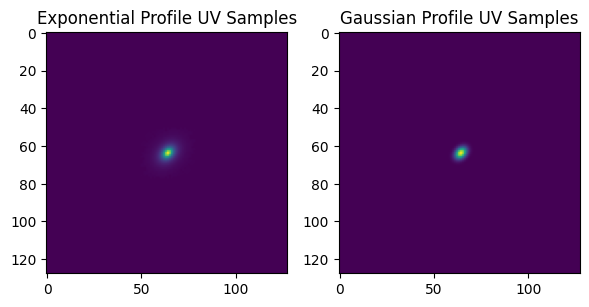

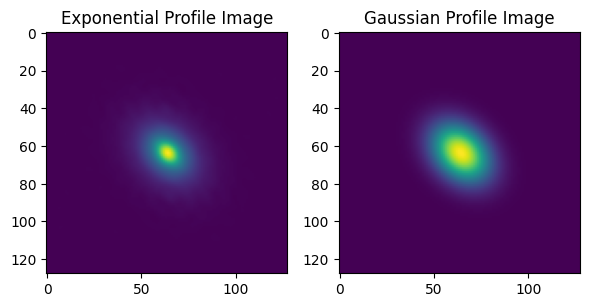

In [8]:
flux = 0.1  # flux of the galaxy
hlr = 1.2  # half-light radius in arcsec

gal_exp_vis = draw_exp_profile(hlr=hlr, flux=flux, e1=0.1, e2=0.2, g1=g1_true, g2=g2_true, uv_pos=uv_pos, Npx=Npx, pixel_scale=pixel_scale)
gal_gaus_vis = draw_gaussian_profile(hlr=hlr, flux=flux, e1=0.1, e2=0.2, g1=g1_true, g2=g2_true, uv_pos=uv_pos, Npx=Npx, pixel_scale=pixel_scale)

# Unstack the real and imaginary parts to complex format
gal_exp_vis = stack_2_complex(gal_exp_vis)
gal_gaus_vis = stack_2_complex(gal_gaus_vis)

gal_exp_uv = np.zeros_like(mask)
gal_exp_uv[uv_pos] = gal_exp_vis

gal_gaus_uv = np.zeros_like(mask)
gal_gaus_uv[uv_pos] = gal_gaus_vis

# Plot the uv samples
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(gal_exp_uv))
plt.title('Exponential Profile UV Samples')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(gal_gaus_uv))
plt.title('Gaussian Profile UV Samples')
plt.tight_layout()
plt.show()

# Plot the galaxies in real space
gal_exp_image = np.abs(np.fft.ifftshift(np.fft.ifft2(gal_exp_uv)))
gal_gaus_image = np.abs(np.fft.ifftshift(np.fft.ifft2(gal_gaus_uv)))

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(gal_exp_image)
plt.title('Exponential Profile Image')
plt.subplot(1, 2, 2)
plt.imshow(gal_gaus_image)
plt.title('Gaussian Profile Image')
plt.tight_layout()
plt.show()


In [9]:
import scipy.stats as stats

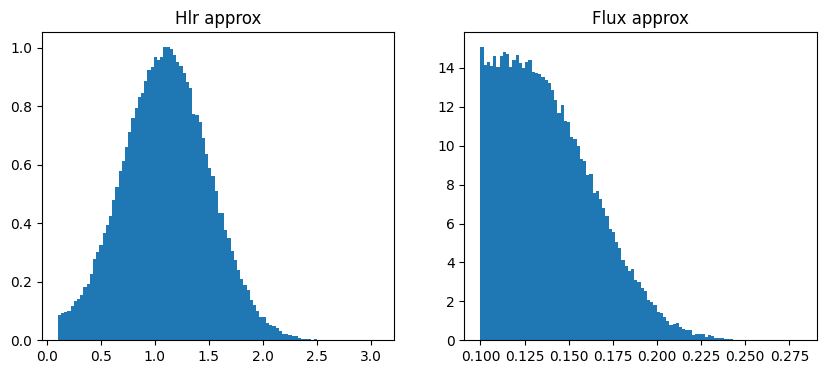

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
vals = np.abs(stats.norm(0, 1).rvs(100000) + 2.5)/2.5 + .1
_=plt.hist(vals, bins=100, density=True)
plt.title('Hlr approx')

plt.subplot(1, 2, 2)
vals = np.abs(stats.norm(0, 1).rvs(100000) + 1. )/30. + .1
_=plt.hist(vals, bins=100, density=True)
plt.title('Flux approx')
plt.show()

In [11]:
params_dir = '../data/trecs_gal_params.npy'

ell_prior_scale = .3
ell_scale = .3
g_prior_scale = .3
g_scale = .3
hlr_offset = 2.5
hlr_scale = 1/2.5
hlr_min = .1
flux_offset = 1.
flux_scale = 1/30.
flux_min = .1

#@partial(jax.jit, static_argnums=(0,1,2,3,4))
def model_fn(Ngal=10, Npx=128, pixel_scale=0.15, uv_pos=None, noise_uv=1e-2, obs=None, params_dir=params_dir, data=False):

    # define parameters and their prior
    params = np.load(params_dir, allow_pickle=True)[()]
    # pixel_scale = params['pixelscale']
    # Npx = params['Npix']

    u = jnp.ones((Ngal,)) # sampling galaxies all at once

    # hlr_fit = params['beta_fit_hlr']
    # hlr = numpyro.sample("hlr", dist.Beta(hlr_fit['a'], hlr_fit['b']), sample_shape=(Ngal,)) * hlr_fit['scale'] + hlr_fit['loc']
    # hlr = jnp.abs((numpyro.sample("hlr", dist.Normal(0.*u, 1.*u)) + 4.) * 1.) + 1e-3
    hlr = jnp.abs((numpyro.sample("hlr", dist.Normal(0.*u, 1.*u)) + hlr_offset)) * hlr_scale + hlr_min

    
    # flux_fit = params['beta_fit_flux']
    # flux = numpyro.sample("flux", dist.Beta(flux_fit['a'], flux_fit['b']), sample_shape=(Ngal,)) * flux_fit['scale'] + flux_fit['loc']
    flux = jnp.abs((numpyro.sample("flux", dist.Normal(0.*u, 1.*u)) + flux_offset)) * flux_scale + flux_min

    # r_ell_fit = params['beta_fit_r_ell']
    # r_ell = numpyro.sample("r_ell", dist.Beta(r_ell_fit['a'], r_ell_fit['b']), sample_shape=(Ngal,)) * r_ell_fit['scale'] + r_ell_fit['loc']
    # angle_ell = numpyro.sample("angle_ell", dist.Uniform(-jnp.pi, jnp.pi), sample_shape=(Ngal,))

    # e1 = r_ell * jnp.cos(angle_ell)
    # e2 = r_ell * jnp.sin(angle_ell)
    e1 = numpyro.sample("e1", dist.Normal(0.*u, ell_prior_scale*u))/ell_prior_scale * ell_scale
    e2 = numpyro.sample("e2", dist.Normal(0.*u, ell_prior_scale*u))/ell_prior_scale * ell_scale


    # assuming constant shear across galaxies
    g1 = numpyro.sample("g1", dist.Normal(jnp.zeros((1,)), g_prior_scale*jnp.ones((1,))))*g_scale/g_prior_scale
    g2 = numpyro.sample("g2", dist.Normal(jnp.zeros((1,)), g_prior_scale*jnp.ones((1,))))*g_scale/g_prior_scale

    # clipping undefined e and g values
    e = jnp.stack([e1, e2], 0)
    e = clip_by_l2_norm(e)

    g = jnp.repeat(jnp.stack([g1, g2], 0), Ngal, -1)
    g = clip_by_l2_norm(g)

    # generate galaxy image
    if data:
        draw = partial(draw_sersic_profile, uv_pos=uv_pos, Npx=Npx, pixel_scale=pixel_scale)
        im_gal = jnp.array([draw(hlr=hlr[i], flux=flux[i], e1=e[0][i], e2=e[1][i], g1=g[0][i], g2=g[1][i]) for i in range(Ngal)])
    else:
        draw = partial(draw_exp_profile, uv_pos=uv_pos, Npx=Npx, pixel_scale=pixel_scale)
        im_gal = jax.vmap(draw)(hlr=hlr,
                            flux=flux, 
                            e1=e[0], 
                            e2=e[1],
                            g1=g[0], 
                            g2=g[1],)
    # add Gaussian noise
    if obs is None:
        return numpyro.sample("obs", dist.Normal(im_gal, noise_uv))
    else:
        return numpyro.sample("obs", dist.Normal(im_gal, noise_uv), obs=data)


# Generate the data

In [12]:
# Generate observations
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
model = partial(model_fn, Ngal=Ngal, Npx=Npx, pixel_scale=pixel_scale,  uv_pos=uv_pos, noise_uv=noise_uv, data=True) 
seeded_model = seed(model, subkey)

# Conditioning model to generate observation with [g1, g2]
conditionned_model = condition(seeded_model, {"g1":g1_true*jnp.ones((1,))/(g_scale/g_prior_scale), "g2":g2_true*jnp.ones((1,))/(g_scale/g_prior_scale)})
data = conditionned_model()

# Reset model for sampling
key, subkey = jax.random.split(key)
model = partial(model_fn, Ngal=Ngal, Npx=Npx, pixel_scale=pixel_scale,  uv_pos=uv_pos, noise_uv=noise_uv, data=False)
seeded_model = seed(model, subkey)

Data shape: (1280, 1280)
Data max: 0.2324307304291133


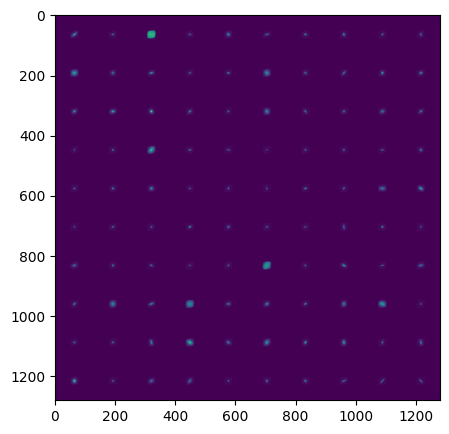

In [13]:
# Plot observations
# data_complex = stack_2_complex(data, batch=True)
data_complex = []
for vis in stack_2_complex(data, batch=True):
    img_aux = np.zeros_like(mask)
    img_aux[uv_pos] = vis
    data_complex.append(img_aux)
data_ = rearrange(data_complex, "(n1 n2) h w -> (n1 h) (n2 w)", n1=10, n2=10)
# data_ = rearrange(data_complex, "(n1 n2) h w -> (n1 h) (n2 w)", n1=10, n2=10)
plt.figure(figsize=(5,5))
plt.imshow(np.abs(data_), vmin=np.min(np.abs(data_)), vmax=np.max(np.abs(data_)))
print('Data shape:', data_.shape)
print('Data max:', np.max(np.abs(data_)))
plt.show()

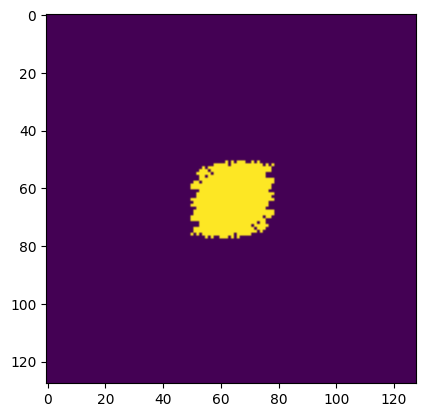

In [14]:
plt.imshow(np.real(mask))

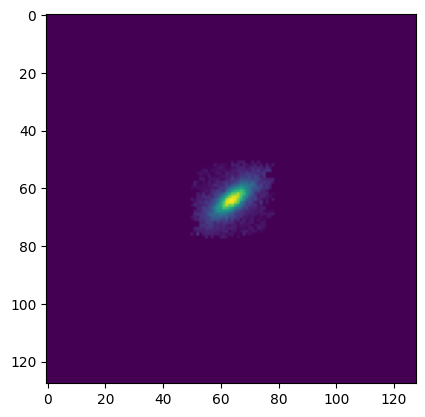

In [15]:
plt.imshow(np.abs(data_[:Npx,:Npx]))

# Init the sampler

In [16]:
def draw_params(key):
    t = trace(seed(model, key)).get_trace()
    return {key:t[key]["value"] for key in t if not key=="obs"}

num_chains = 10

keys = jax.random.split(key, num_chains)[:num_chains]
init_val_ = jax.vmap(draw_params)(keys)

In [17]:
# _=plt.hist(np.abs(init_val_['hlr'].reshape(-1)+hlr_offset)*hlr_scale+hlr_min, bins=50)
# _=plt.hist(np.abs(init_val_['hlr'].reshape(-1)+hlr_offset), bins=15)


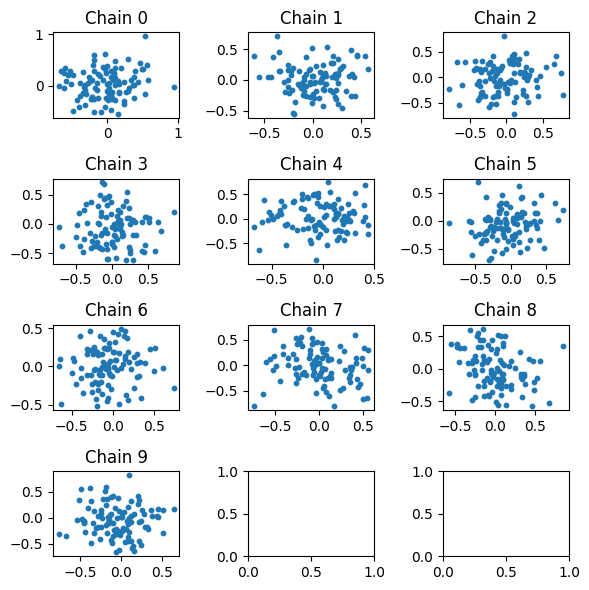

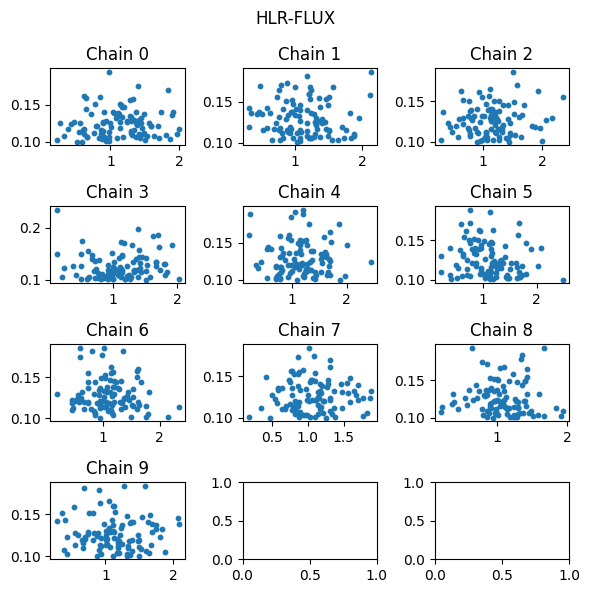

In [18]:
fig, ax = plt.subplots(4,3, figsize=(6, 6))
for idx in range(10):
    i, j = np.unravel_index(idx, (4, 3))
    ax[i,j].scatter(init_val_['e1'][idx,:], init_val_['e2'][idx,:], s=10)
    ax[i,j].set_title(f'Chain {idx}')
plt.tight_layout()

fig, ax = plt.subplots(4,3, figsize=(6, 6))
plt.suptitle("HLR-FLUX")
for idx in range(10):
    i, j = np.unravel_index(idx, (4, 3))
    ax[i,j].scatter(np.abs(init_val_['hlr'][idx,:]+hlr_offset)*hlr_scale+hlr_min, 
                    np.abs(init_val_['flux'][idx,:])*flux_scale+flux_min, s=10)
    ax[i,j].set_title(f'Chain {idx}')
plt.tight_layout()

In [19]:
# Get the log prob of the joint distribution, conditioned on data
@jax.jit
def log_prob_fn(params):
    return numpyro.infer.util.log_density(model, (), {"obs":data,}, params)[0]

# MAP params
lr_map = 1e-3
n_steps_map = 1_000

# find the MAP for chain initialization
nll = lambda params: -log_prob_fn(params)

def find_map(init_params):
    start_learning_rate = lr_map
    optimizer = optax.adafactor(start_learning_rate)

    opt_state = optimizer.init(init_params)

    # A simple update loop.
    def update_step(carry, xs):
        params, opt_state = carry
        grads = jax.grad(nll)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), 0.

    (params, _) , _ = jax.lax.scan(update_step, (init_params, opt_state), length=n_steps_map)

    return params

init_val = jax.vmap(find_map)(init_val_)

print(init_val["g1"]*g_scale/g_prior_scale, init_val["g2"]*g_scale/g_prior_scale)

[[-0.253562  ]
 [-0.09597014]
 [-0.28706908]
 [ 0.99372375]
 [ 0.82906765]
 [-0.53612393]
 [ 0.00775027]
 [-0.49716663]
 [-0.00282493]
 [-0.12478288]] [[ 0.4455785 ]
 [ 0.6893819 ]
 [ 0.24065071]
 [-0.1404664 ]
 [ 0.5789394 ]
 [-0.7137335 ]
 [ 0.02924619]
 [-0.7080914 ]
 [-0.07535832]
 [ 0.98686206]]


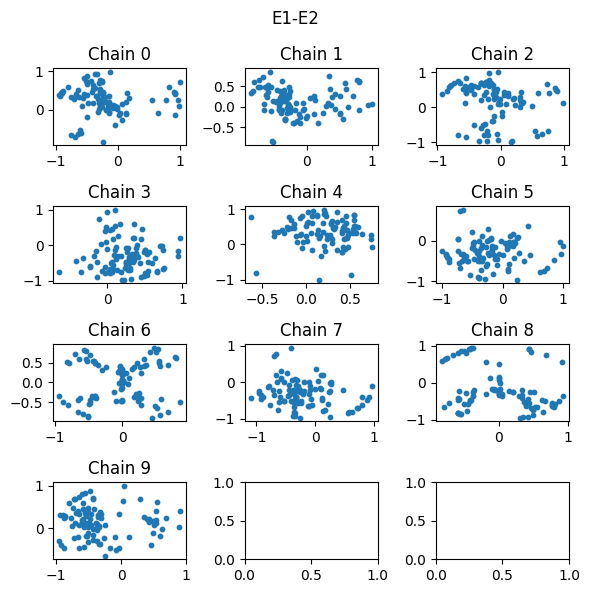

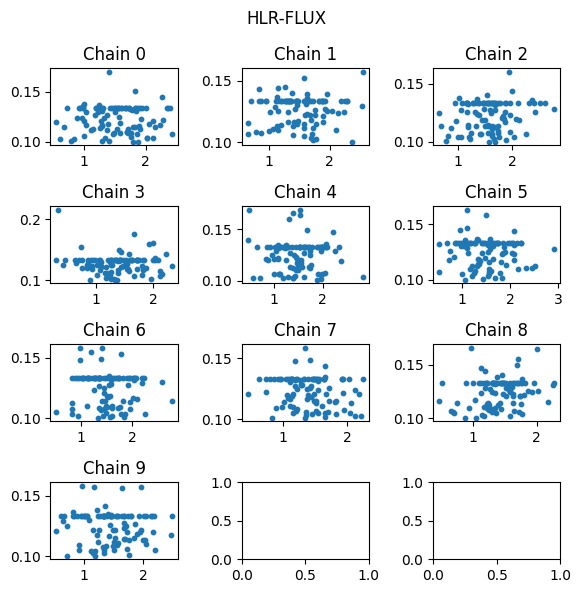

In [20]:
fig, ax = plt.subplots(4,3, figsize=(6, 6))
plt.suptitle("E1-E2")
for idx in range(10):
    i, j = np.unravel_index(idx, (4, 3))
    ax[i,j].scatter(init_val['e1'][idx,:], init_val['e2'][idx,:], s=10)
    ax[i,j].set_title(f'Chain {idx}')
plt.tight_layout()

fig, ax = plt.subplots(4,3, figsize=(6, 6))
plt.suptitle("HLR-FLUX")
for idx in range(10):
    i, j = np.unravel_index(idx, (4, 3))
    ax[i,j].scatter(np.abs(init_val['hlr'][idx,:]+hlr_offset)*hlr_scale+hlr_min, 
                    np.abs(init_val['flux'][idx,:])*flux_scale+flux_min, s=10)
    ax[i,j].set_title(f'Chain {idx}')
plt.tight_layout()

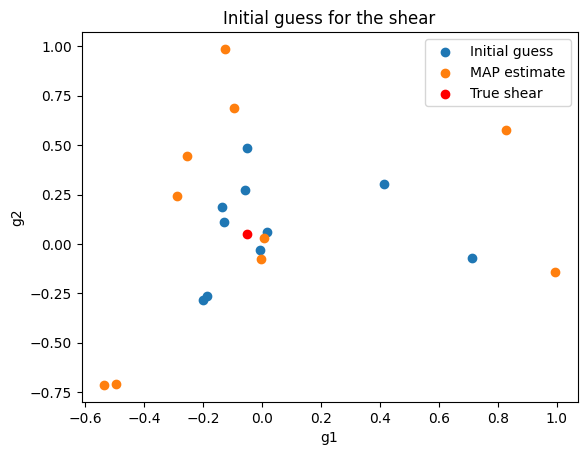

In [21]:
# Plot the initial guess for the shear
plt.figure()
plt.scatter(init_val_["g1"]*g_scale/g_prior_scale, init_val_["g2"]*g_scale/g_prior_scale, label='Initial guess')
plt.scatter(init_val["g1"]*g_scale/g_prior_scale, init_val["g2"]*g_scale/g_prior_scale, label='MAP estimate')
plt.scatter(g1_true, g2_true, color='red', label='True shear')
plt.xlabel('g1')
plt.ylabel('g2')
plt.title('Initial guess for the shear')
plt.legend()
plt.show()

In [22]:
warmup = blackjax.meads_adaptation(
            log_prob_fn,
            num_chains=num_chains,
        )

key_warmup, key_sample = jax.random.split(key)

(last_states, parameters), _ = warmup.run(
            key_warmup,
            init_val,
            num_steps=500,
        )

print('Step size:',parameters["step_size"])
parameters["step_size"] = 0.005
print('Set step size to:',parameters["step_size"])


Step size: 4.4624276e-06
Set step size to: 0.005


In [23]:
init_val.keys()

dict_keys(['e1', 'e2', 'flux', 'g1', 'g2', 'hlr'])

In [24]:
parameters

{'step_size': 0.005,
 'momentum_inverse_scale': {'e1': Array([0.22974049, 0.5598791 , 0.47856274, 0.30220327, 0.41247696,
         0.32577443, 0.48427856, 0.5547484 , 0.41045272, 0.4450392 ,
         0.50565255, 0.51976776, 0.4291659 , 0.45244783, 0.38264132,
         0.47756857, 0.42571115, 0.42021877, 0.45876393, 0.43115   ,
         0.50149006, 0.6246639 , 0.45237422, 0.53840595, 0.5029603 ,
         0.38101542, 0.42944348, 0.40511906, 0.501096  , 0.4384983 ,
         0.49360633, 0.5393303 , 0.5211474 , 0.3801143 , 0.41354084,
         0.3754572 , 0.3949895 , 0.41484743, 0.39853752, 0.37086955,
         0.43968475, 0.46302173, 0.53532594, 0.6494377 , 0.38867623,
         0.3721229 , 0.27190575, 0.29774827, 0.28172103, 0.438411  ,
         0.48007652, 0.29230344, 0.32175207, 0.24750182, 0.46254385,
         0.46850324, 0.23105136, 0.47587553, 0.5308145 , 0.37092385,
         0.45818585, 0.5110214 , 0.36351332, 0.35399944, 0.4699551 ,
         0.65733653, 0.1673106 , 0.35512677, 0.411

In [25]:
last_states.position['g2']

Array([[ 0.45434865],
       [ 0.7066069 ],
       [ 0.24394791],
       [-0.14274341],
       [ 0.5799497 ],
       [-0.7255388 ],
       [ 0.02726776],
       [-0.7241242 ],
       [-0.10568289],
       [ 0.9870473 ]], dtype=float32)

In [26]:
last_states.position

{'e1': Array([[-8.82139802e-02, -7.21317470e-01, -3.66291881e-01,
          1.36177078e-01, -6.38367593e-01, -1.61424592e-01,
         -6.97788119e-01,  8.22389483e-01, -3.98590833e-01,
         -3.16315353e-01,  1.26388103e-01, -9.26806778e-03,
         -4.82324243e-01, -6.09788120e-01,  5.48395097e-01,
          9.75505888e-01, -8.12496841e-01, -2.87210584e-01,
         -9.27650809e-01, -1.51019990e-01, -9.04042602e-01,
          9.04627025e-01, -5.02408803e-01, -5.49022973e-01,
         -5.26295483e-01, -9.07349706e-01, -4.49471846e-02,
         -2.95423210e-01, -3.33407849e-01, -2.26946279e-01,
         -1.88665211e-01, -8.86015236e-01, -2.91510671e-01,
         -3.51481795e-01,  9.29011285e-01,  1.38993427e-01,
          1.30266666e-01, -2.47962356e-01, -3.16076130e-01,
          6.53066814e-01,  3.64270173e-02, -2.41189972e-01,
          1.89583935e-02, -2.00628504e-01, -4.27736863e-02,
         -4.97903317e-01, -2.66817391e-01, -1.42699063e-01,
         -5.72390616e-01,  1.71724

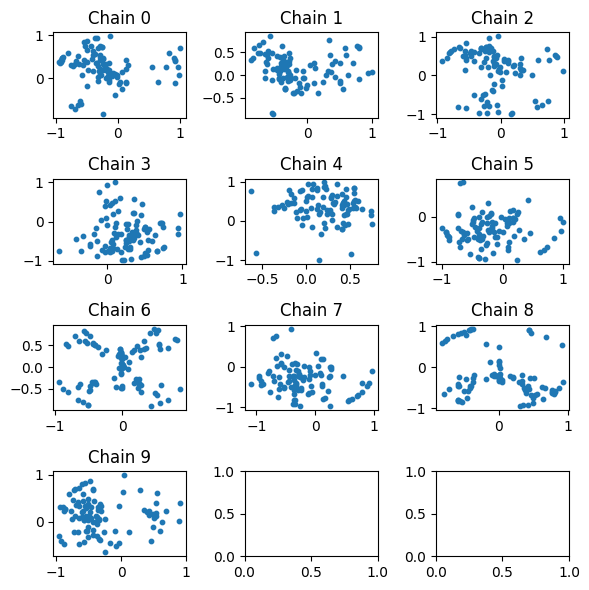

In [27]:
fig, ax = plt.subplots(4,3, figsize=(6, 6))
for idx in range(10):
    i, j = np.unravel_index(idx, (4, 3))
    ax[i,j].scatter(last_states.position['e1'][idx,:], last_states.position['e2'][idx,:], s=10)
    ax[i,j].set_title(f'Chain {idx}')
plt.tight_layout()

In [28]:
kernel = blackjax.ghmc(log_prob_fn, **parameters)

@partial(jax.jit, static_argnames=("num_steps",))
def run_hmc(init_states, key, num_steps=1):
    
    def make_step(state, key):
        state, info = kernel.step(key, state)
        return state, (state, info)
    
    keys = jax.random.split(key, num_steps)
    last_states, (samples, info) = jax.lax.scan(make_step, init_states, keys)

    return last_states, (samples, info)

# loop over lax.scan to save GPU memorry
num = 4
num_steps = 1_0

key_chains = jax.random.split(key_sample, num_chains)

last_states, _ = jax.vmap(lambda init_states, keys: run_hmc(init_states, keys, 1))(last_states, key_chains)

sample_list = []

keys = jax.vmap(jax.random.split, in_axes=(0,None))(key_chains,num)

for i in range(num):
    print("Chain", i+1, "of", 2*num, "running...")
    last_states, (samples, info) = jax.vmap(lambda init_states, keys: run_hmc(init_states, keys, num_steps))(last_states, keys[:,i,:])
    sample_list.append(samples)

samples_ = {key: np.concatenate([sample_list[k].position[key] for k in range(num)], 1) for key in last_states.position}

Chain 1 of 8 running...
Chain 2 of 8 running...
Chain 3 of 8 running...
Chain 4 of 8 running...


(10, 40, 100)


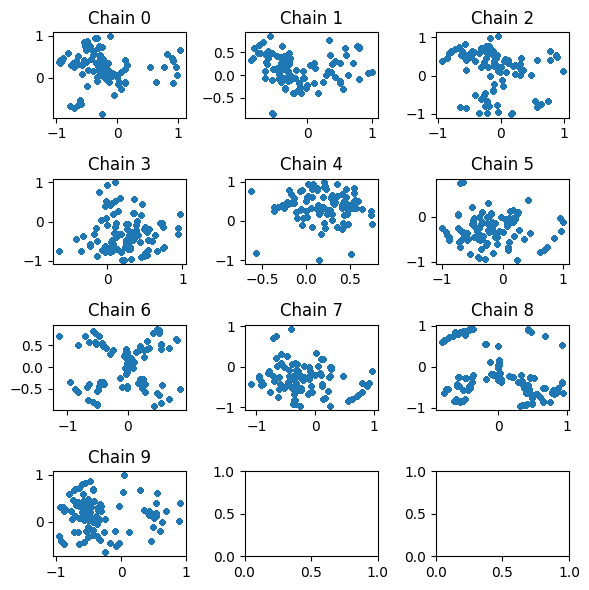

In [29]:
print(samples_['e1'].shape)

fig, ax = plt.subplots(4,3, figsize=(6, 6))
for idx in range(10):
    i, j = np.unravel_index(idx, (4, 3))
    ax[i,j].scatter(samples_['e1'][idx,:], samples_['e2'][idx,:], s=10)
    ax[i,j].set_title(f'Chain {idx}')
plt.tight_layout()


In [30]:
print("ESS g1", blackjax.diagnostics.effective_sample_size(samples_["g1"][...,0]))
print("ESS g2", blackjax.diagnostics.effective_sample_size(samples_["g2"][...,0]))
print("ESS hlr", blackjax.diagnostics.effective_sample_size(samples_["hlr"][...,0]))
print("ESS flux", blackjax.diagnostics.effective_sample_size(samples_["flux"][...,0]))
print("ESS e1", blackjax.diagnostics.effective_sample_size(samples_["e1"][...,0]))
print("ESS e2", blackjax.diagnostics.effective_sample_size(samples_["e2"][...,0]))

ESS g1 5.2085943
ESS g2 5.2565494
ESS hlr 5.129341
ESS flux 5.1290445
ESS e1 5.1282053
ESS e2 5.128211


In [31]:
# extra chains
for i in range(num):
    print("Extra chain", num+i+1, "of", 2*num, "running...")
    last_states, (samples, info) = jax.vmap(lambda init_states, keys: run_hmc(init_states, keys, num_steps))(last_states, keys[:,i,:])
    sample_list.append(samples)

# concatenates chains
samples_ = {key: np.concatenate([sample_list[k].position[key] for k in range(num*2)], 1) for key in last_states.position}


Extra chain 5 of 8 running...
Extra chain 6 of 8 running...
Extra chain 7 of 8 running...
Extra chain 8 of 8 running...


(10, 80, 100)


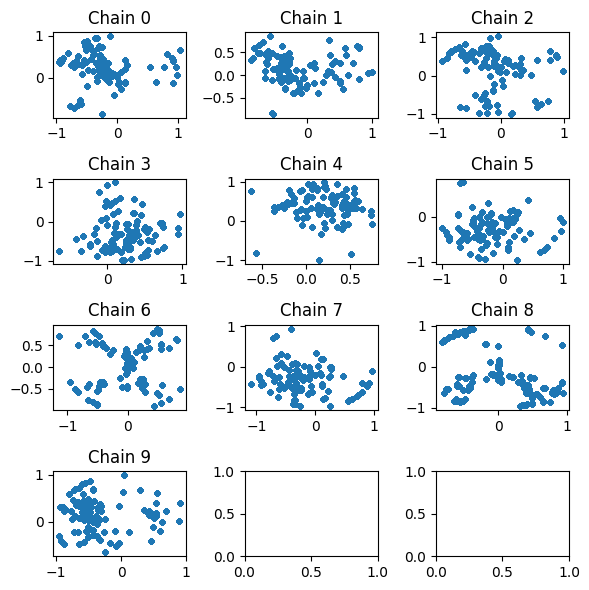

In [32]:
print(samples_['e1'].shape)

fig, ax = plt.subplots(4,3, figsize=(6, 6))
for idx in range(10):
    i, j = np.unravel_index(idx, (4, 3))
    ax[i,j].scatter(samples_['e1'][idx,:], samples_['e2'][idx,:], s=10)
    ax[i,j].set_title(f'Chain {idx}')
plt.tight_layout()


0 hlr
1 flux
2 e1
3 e2
4 g1
5 g2


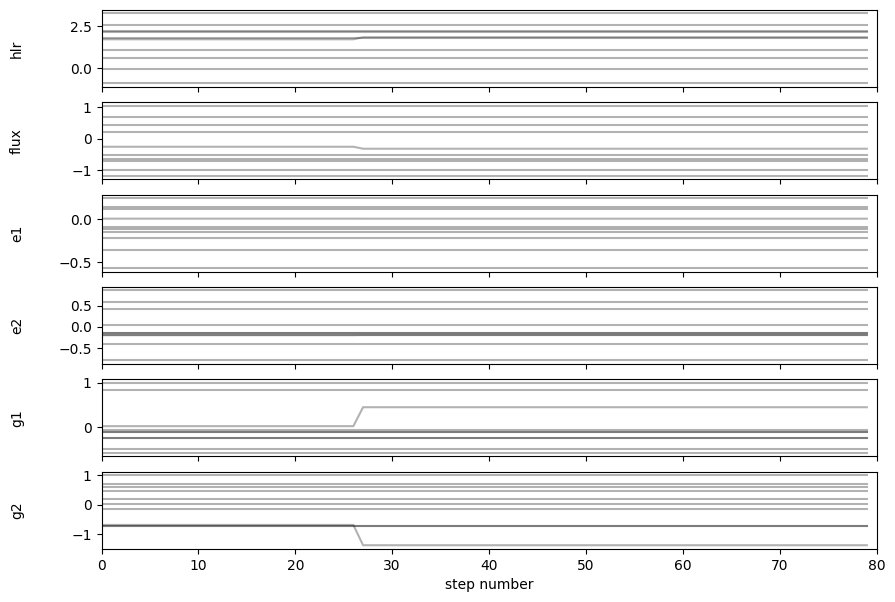

In [33]:
# labels = ["hlr", "flux", "r_ell", "angle_ell", "g1", "g2"]
labels = ["hlr", "flux", "e1", "e2", "g1", "g2"]
params_scales = np.load(params_dir, allow_pickle=True)[()]

fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)

for i, label in enumerate(labels):
    print(i, label)
    ax = axes[i]
    for k in range(num_chains):
        # if label in ["g1", "g2"]:
        #     ax.plot(samples_[label][k,:,0]*0.1, "k", alpha=0.3)
        # else:
        #     ax.plot(samples_[label][k,:,0], "k", alpha=0.3)
        ax.plot(samples_[label][k,:,0], "k", alpha=0.3)
    ax.set_xlim(0, num_steps*num*2)
    ax.set_ylabel(label)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [34]:
info.acceptance_rate

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)